In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

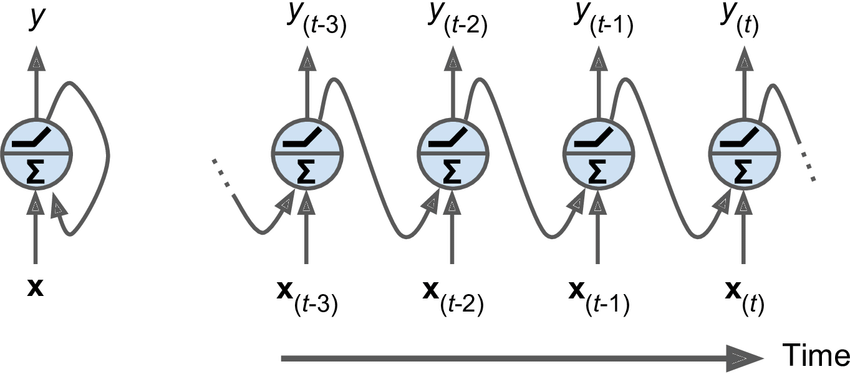

Rys. 1 Neuron rekurencyjny (po lewej), rozwijany po czasie (po prawej)

Źródło: https://www.researchgate.net/figure/A-recurrent-neuron-left-unrolled-through-time-right-2_fig4_351547862

Podstawowe pojęcia:
* Rekurencyjna sieć neuronowa (ang. **RNN**) - składa się z neuronów rekurencyjnych (rys.1), zawierających połączenia wsteczne
* W każdym **takcie** t (ang. time step / frame) **neuron rekurencyjny** otrzymuje sygnały wejściowe x(t) oraz wynik wygenerowany przez siebie w poprzednim takcie y(t-1)
* Każdy neuron rekurencyjny zawiera dwa zestawy **wag** - wx i wy
* **Komórka pamięci** - wyjście neuronu rekurencyjnego w takcie t stanowi funkcję wszystkich danych wejściowych z poprzednich ramek czasowych, komórka pamięci zachowuje informacje o poprzednich taktach
* Propagacja wsteczna w czasie - najpierw rozwijamy sieć w czasie, potem klasyczny algorytm

Rodzaje sieci rekurencyjnych:
* sekwencyjna - prognozowanie np. ceny akcji, wyniki są przesunięte o 1 (N dni (x) -> od N-1 do jutra (y)
* sekwencyjno-wektorowa - przekazujemy sekwencję danych wejściowych i ignorujemy wszystkie wyniki oprócz ostatniego np. sekwencja słów pochodzących z komentarzy -> nastawienie użytkownika do produktu
* wektorowo-sekwencyjna - obraz -> opis obrazu
* koder-dekoder - koder przekształca sekwencję na wektor, dekoder wektor na sekwencję np. tłumaczenie zdania na inny język: zdanie (sekwencja) -> ogólna myśl (wektor) -> zdanie w innym języku (sekwencja)

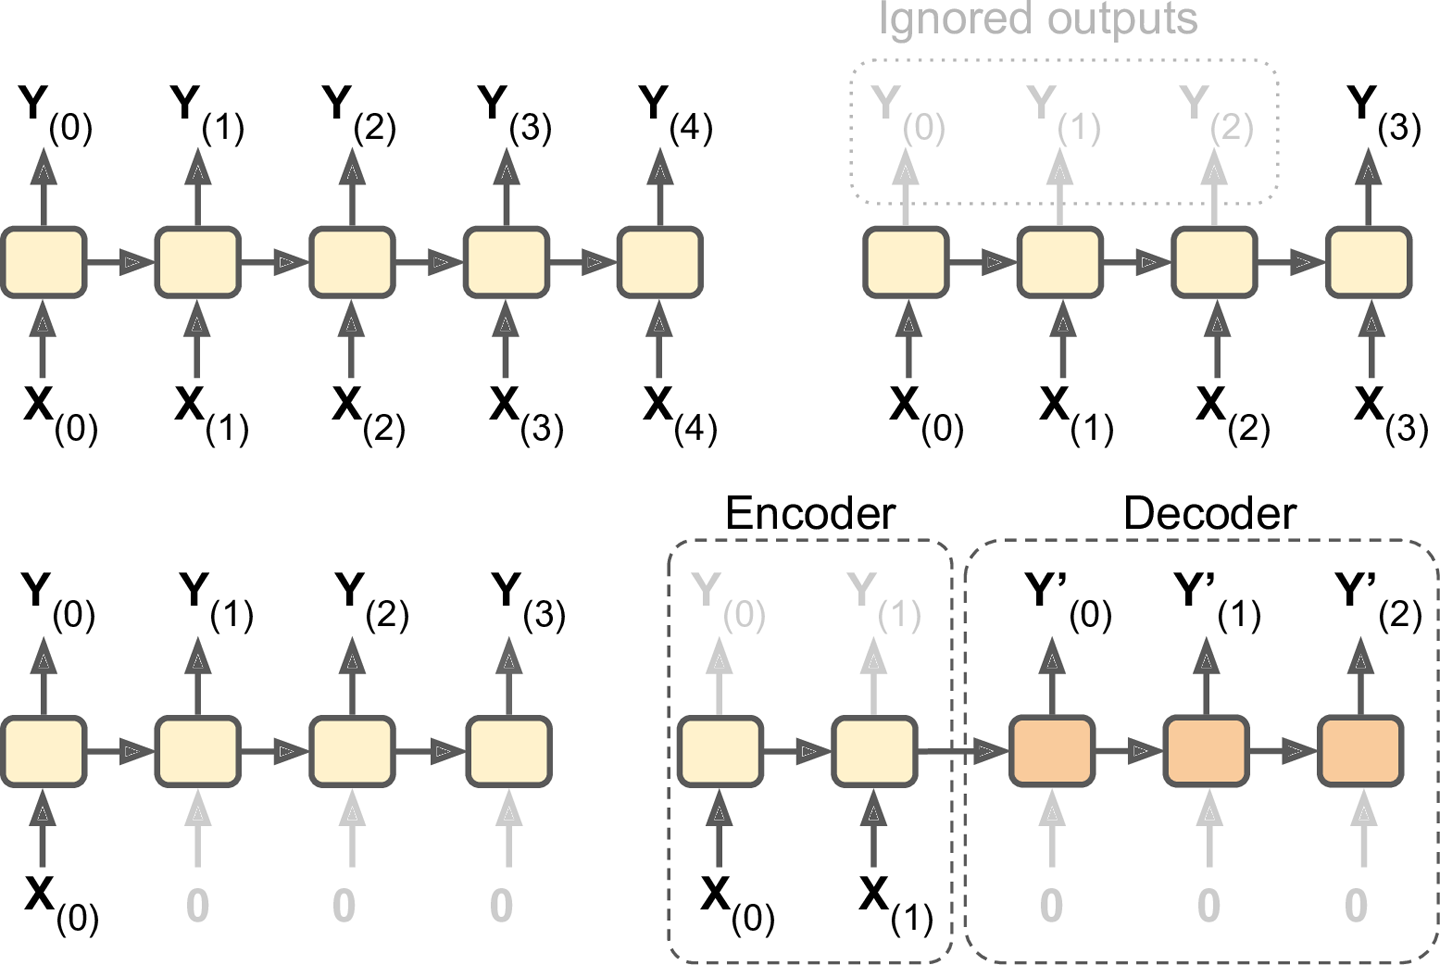
Rys. 2 Architektury sieci neuronowych

https://www.oreilly.com/library/view/neural-networks-and/9781492037354/ch04.html

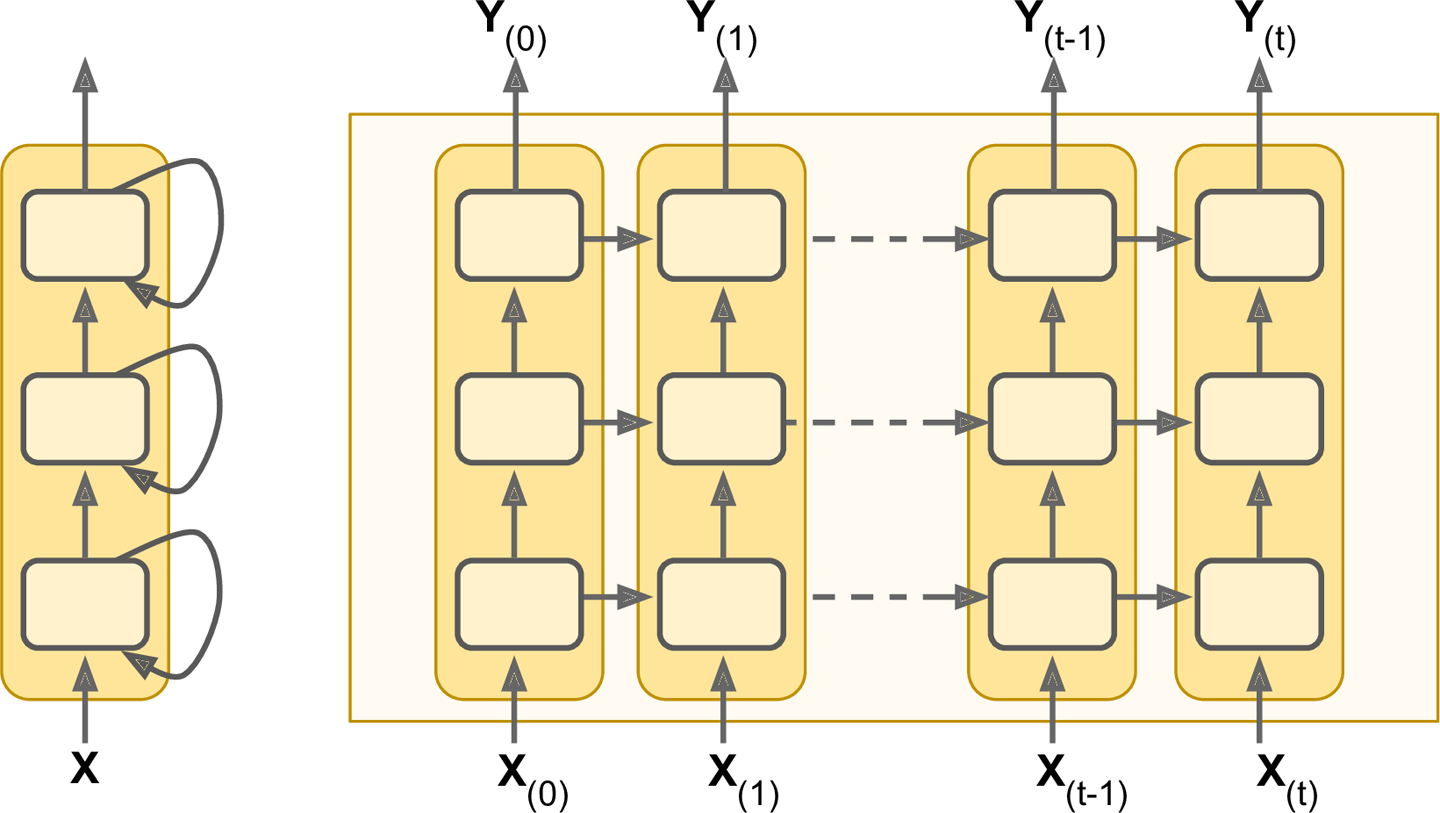

Rys.3 Głęboka sieć rekurencyjna

https://www.oreilly.com/library/view/neural-networks-and/9781492037354/ch04.html

Dla chętnych:
* komórka LSTM

In [ ]:
from tensorflow import keras

In [ ]:
TPS_file_path = '../input/tabular-playground-series-jul-2021/train.csv'
TPS_data = pd.read_csv(TPS_file_path)
TPS_data.shape

In [ ]:
pd.concat([TPS_data.head(3), TPS_data.tail(3)])

In [ ]:
first_time = TPS_data.date_time[0]
last_time = TPS_data.date_time[7110]

from datetime import datetime

first_time = datetime.strptime(first_time, '%Y-%m-%d %H:%M:%S')
last_time = datetime.strptime(last_time, '%Y-%m-%d %H:%M:%S')

#[first_time, last_time]

diff = last_time - first_time
diff.total_seconds()/3600 # teraz mamy pewność, że nasze dane podawane są co godzinę bez żadnych braków

In [ ]:
TPS_data.set_index('date_time', inplace=True)
TPS_data.head()

In [ ]:
X_cols = ['deg_C', 'relative_humidity', 'absolute_humidity',
          'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']

y_cols = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']

In [ ]:
train_set = TPS_data[:6400]
valid_set = TPS_data[6400:]

train_X = train_set[X_cols]
valid_X = valid_set[X_cols]

train_y = train_set[y_cols]
valid_y = valid_set[y_cols]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
valid_X = scaler.transform(valid_X)

Tym razem przekształcimy nasze dane konkretnie pod RNN. W poprzednich zadaniach każdy wiersz był osobnym obrazkiem/mieszkaniem/klientem... Teraz jednak nasze dane są ze sobą ściśle powiązane (czas) i musimy to uwzględnić w naszym modelu. Wykorzystujemy do tego keras.preprocessing. Łączymy dane treningowe (1600 wierszy) w podzbiory po 50 wierszy/godzin. Model pobiera dane z pierwszych 49 godzin i przewiduje co się stanie w 50 godzinie. Następnie oblicza funkcję straty i stara się poprawić. Dalej przewiduje z 2-50 na 51 godzinę i tak do momentu kiedy wyuczy się z 6400 wierszy. Podobnie podzielimy zbiór walidacyjny. Stride oznacza długość kroku pomiędzy kolejnymi y. W naszym przypadku stride=1. Nic nie stoi jednak na przykładzie, żeby sprawdzić 50,53,56,59... y (stride=3). Zauważ, że batch_size nie wynosi już 32 a 1. Każdą kolejną obserwację (50 wierszy) sprawdzamy pojedynczo.

In [ ]:
length=50
stride=3
batch_size=1

from tensorflow.keras.preprocessing import timeseries_dataset_from_array

train_generator = timeseries_dataset_from_array(data=train_X,
                                      targets=train_y,
                                      sequence_length=length,
                                      sequence_stride=stride,
                                      batch_size=batch_size)

valid_generator = timeseries_dataset_from_array(data=valid_X,
                                      targets=valid_y,
                                      sequence_length=length,
                                      sequence_stride=stride,
                                      batch_size=batch_size)

In [ ]:
n_features = train_X.shape[1]
n_targets = train_y.shape[1]

from tensorflow.keras import layers

model = keras.Sequential([
    layers.SimpleRNN(length, return_sequences=True, input_shape=[length, n_features]),
    layers.SimpleRNN(20),
    layers.Dense(n_targets)
])

In [ ]:
model.compile(optimizer="adam", loss="msle")

In [ ]:
history = model.fit(train_generator, epochs=15,
                    validation_data=valid_generator)

In [ ]:
TEST_data_filepath = '../input/tabular-playground-series-jul-2021/test.csv'
TEST_data = pd.read_csv(TEST_data_filepath)

TEST_data.columns

In [ ]:
date_time = TEST_data.date_time

TEST_data.set_index('date_time', inplace=True)

In [ ]:
TEST_data = scaler.transform(TEST_data)

In [ ]:
TEST_data = np.concatenate((valid_X[-50:], TEST_data), axis=0)

In [ ]:
TEST_generator = timeseries_dataset_from_array(data=TEST_data,
                                               targets=None,
                                               sequence_length=length,
                                               sequence_stride=stride,
                                               batch_size=batch_size)

In [ ]:
preds = model.predict(TEST_generator)
preds

In [ ]:
preds.shape # pierwszy rząd targetów dotyczy ostatniej obserwacji w zbiorze walidacyjnym

In [ ]:
TEST_data.shape

In [ ]:
target_carbon_monoxide = preds[1:,0]
target_benzene = preds[1:,1]
target_nitrogen_oxides = preds[1:,2]

In [ ]:
output = pd.DataFrame({'date_time': date_time,
                       'target_carbon_monoxide': target_carbon_monoxide,
                       'target_benzene': target_benzene,
                       'target_nitrogen_oxides': target_nitrogen_oxides})
output.to_csv('submission.csv', index=False)